In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import arviz as az
from statsmodels.tsa import stattools
import statsmodels.api as sm
import pymc3 as pm
import pymc

import sys
sys.path.insert(0, '..')
from utils.plot_lib import set_default

set_default(figsize=(6, 4))

### Mixture models for density estimation 

The galaxies dataset. 

In [2]:
!wget http://www.key2stats.com/Velocities_for_82_Galaxies_1152_58.csv -O galaxy.csv --no-check-certificate

--2021-05-24 11:30:43--  http://www.key2stats.com/Velocities_for_82_Galaxies_1152_58.csv
Resolving www.key2stats.com (www.key2stats.com)... 52.207.128.24
Connecting to www.key2stats.com (www.key2stats.com)|52.207.128.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1221 (1,2K) [application/csv]
Saving to: ‘galaxy.csv’

galaxy.csv          100%[===================>]   1,19K  --.-KB/s    in 0s      

2021-05-24 11:30:44 (3,63 MB/s) - ‘galaxy.csv’ saved [1221/1221]



In [3]:
# Read dataset - galaxies
galaxy = pd.read_csv('galaxy.csv')
galaxy.pop('Unnamed: 0')
galaxy.pop('X')
# Checking dataframe
print("The shape of the dataset is: {}".format(galaxy.shape))
galaxy.head()

The shape of the dataset is: (82, 1)


,dat
0,9172
1,9350
2,9483
3,9558
4,9775


These are velocities of galaxies measured in six well-separated conic sections of the Corona Borealis.
So we want to understand whether this distribution is  multimodal, how many modes are present, and in general provide
a density estimator for this different velocities.  

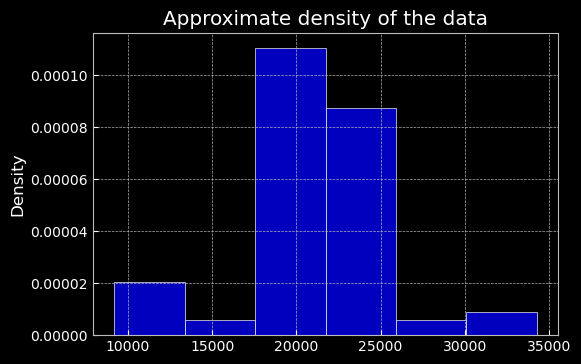

In [4]:
from scipy.stats import norm

## Clear the environment and load required libraries
np.random.seed(1)

### Loading data and setting up global variables
KK         = 6       # We're going to be using six components in our density estimators using mixture models. 
x          = galaxy['dat'].to_numpy() # Data
n          = len(x)

sns.histplot(x, stat= 'density', bins = 6)
plt.title('Approximate density of the data')
plt.show()

In [5]:
### First, compute the "Maximum Likelihood" density estimate associated with a location mixture of 6 Gaussian distributions using the EM algorithm
## Initialize the parameters

## Initialize the parameters
w     = np.ones(KK) / KK                         # Assign equal weight to each component to start with
mu    = norm.rvs(loc = np.mean(x), scale = np.std(x), size = KK)   # Random cluster centers randomly spread over the support of the data
sigma = np.std(x) / KK                  # Initial standard deviation 

print('The initial guess for mu are: \n{}'.format(mu))
print('The initial guess for sigma are: {}'.format(sigma))

The initial guess for mu are: 
[28195.94926738 18053.3385597  18432.46561473 15961.35154374
 24753.52546142 10388.74831008]
The initial guess for sigma are: 755.9741399507708


### MLE EM algorithm

The iteration 1 has a Q value of -2.273882724488057e-15
The iteration 2 has a Q value of -9.695342114157089e-08
The iteration 3 has a Q value of -7.373874301861718e-08
The iteration 4 has a Q value of -2.8723033738928338e-08
The iteration 5 has a Q value of -2.0978876550599337e-08
The iteration 6 has a Q value of -1.9896787060702164e-08
The iteration 7 has a Q value of -2.0520085583274648e-08
The iteration 8 has a Q value of -2.1480242425242425e-08
The iteration 9 has a Q value of -2.2364050638849752e-08
The iteration 10 has a Q value of -2.3071142483565767e-08
The iteration 11 has a Q value of -2.360434359700346e-08
The iteration 12 has a Q value of -2.3994848055055625e-08
The iteration 13 has a Q value of -2.427639503358452e-08
The iteration 14 has a Q value of -2.447757511567058e-08
The iteration 15 has a Q value of -2.4620553493403924e-08
The iteration 16 has a Q value of -2.4721818215931134e-08
The iteration 17 has a Q value of -2.4793372367146036e-08
The iteration 18 has a Q valu

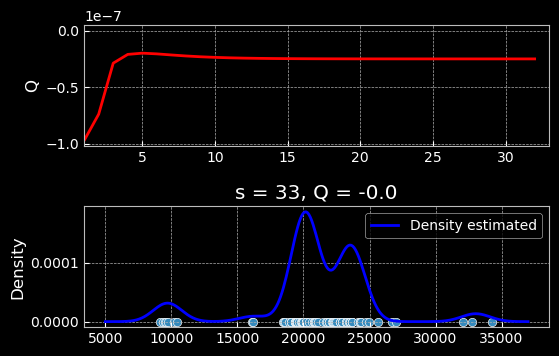

In [6]:
from scipy.stats import lognorm

s  = 0     # Counter of the current iteration
sw = False # Decide when the algorithm will end
KL = np.NINF  # Value of Q to monitor convergence
KL_out = []
epsilon = 10e-6  # Stopping criteria

## Checking convergence of the algorithm
while(not sw):
  ## Expectation (E) step
  v = np.zeros((n, KK))
  for k in range(KK):
    v[:, k] = np.log(w[k]) + norm.logpdf(loc = mu[k], scale = sigma, x = x)
  for i in range(n):
    v[i, :] = np.exp(v[i, :] - max(v[i, : ])) / np.sum(np.exp(v[i, :] - max(v[i, :])))  # Go from logs to actual weights in a numerically stable manner
  
  ## Maximization (M) step
  # Weights
  w = np.mean(v, axis = 0)
  # Mus
  mu = np.zeros(KK)
  for k in range(KK):
    for i in range(n):
      # Update Mu
      mu[k] = mu[k] + (v[i,k] * x[i])
    mu[k] = mu[k] / np.sum(v[:, k])

  # Standard deviations
  sigma = 0
  for i in range(n):
    for k in range(KK):
      sigma = sigma + (v[i,k] * ((x[i] - mu[k])**2))
  sigma = np.sqrt(sigma / np.sum(v))

  ##Check convergence
  KLn = 0 # Value of Q function at current iteration
  for i in range(n):
    for k in range(k):
      KLn = KLn + v[i, k]*(np.log(w[k]) + norm.logpdf(loc = mu[k], scale =sigma, x = x[i]))
  
  # If relative error is less than epsilon stop
  if(np.abs(KLn - KL) / np.abs(KLn) < epsilon):
    sw = True

  KL = KLn
  KL_out.append(KL)
  s = s + 1
  print('The iteration {} has a Q value of {}'.format(s, KLn))

fig, axs = plt.subplots(2)
axs[0].plot(KL_out[0 : s], c = 'red')
axs[0].set_ylabel('Q')
axs[0].axis(xmin = 1, xmax = max(10, s))
axs[1].set_title("Q-value over iterations")

# Estimate of the density
xx = np.linspace(5000, 37000, num = 300)
nxx = len(xx)
density_EM = np.zeros(nxx)
for s_ in range(nxx):
  for k in range(KK):
    density_EM[s_] = density_EM[s_] +  w[k] * norm.pdf(loc = mu[k], scale = sigma, x = xx[s_])

# Plot the initial guess for the density
axs[1].plot(xx, density_EM, 'blue', label = 'Density estimated')
axs[1] = sns.scatterplot(np.array(x), np.zeros(len(x)))
axs[1].set_ylabel('x')
axs[1].set_ylabel('Density')
axs[1].set_title("s = {}, Q = {}".format(s, np.round(KL_out[s - 1], 4)))
fig.subplots_adjust(hspace=0.5)
plt.show()

### Bayesian EM algorithm

This is the same model used in L5A.

In [7]:
### Get a "Bayesian" kernel density estimator based on the same location mixture of 6 normals
## Priors set up using an "empirical Bayes" approach
aa  = np.ones(KK)  # Uniform prior on w
eta = np.mean(x)          # Mean for the prior on mu_k
tau = np.sqrt(np.var(x))  # Standard deviation for the prior for mu_l
dd  = 2          # Inverse gamma prior for sigma_2, parameter d
qq  = np.var(x) / KK          # Inverse gamma prior for sigma_2, parameter q

## Initialize the parameters
## Initialize the parameters
w     = np.ones(KK) / KK                        # Assign equal weight to each component to start with
mu    = norm.rvs(loc = np.mean(x), scale = np.std(x), size = KK, random_state = 1) # Random cluster centers randomly spread over the support of the data
sigma = np.std(x) / KK                   # Initial standard deviation
cc    = np.random.choice(np.arange(KK), n, p = w)

Current iteration is: 0
Current iteration is: 500
Current iteration is: 1000
Current iteration is: 1500
Current iteration is: 2000
Current iteration is: 2500
Current iteration is: 3000
Current iteration is: 3500
Current iteration is: 4000
Current iteration is: 4500
Current iteration is: 5000
Current iteration is: 5500
Current iteration is: 6000
Current iteration is: 6500
Current iteration is: 7000
Current iteration is: 7500
Current iteration is: 8000
Current iteration is: 8500
Current iteration is: 9000
Current iteration is: 9500
Current iteration is: 10000
Current iteration is: 10500
Current iteration is: 11000
Current iteration is: 11500


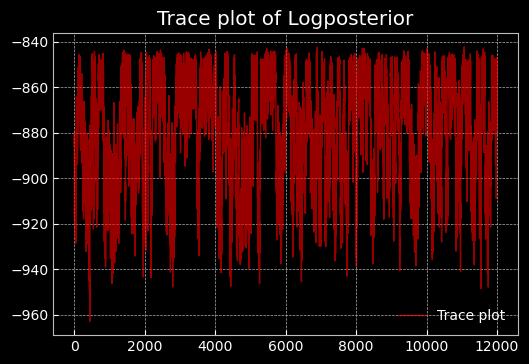

In [8]:
from scipy.stats import dirichlet
from scipy.stats import invgamma
from scipy.stats import gamma

# Number of iterations of the sampler
rrr   = 12000 # Number of iterations
burn  = 3000 # Burning period

# Storing the samples
cc_out    = np.zeros((rrr, n))    # Store indicators
w_out     = np.zeros((rrr, KK))         # Sample of the weights
mu_out    = np.zeros((rrr, KK))   # Sample of mus
sigma_out = np.zeros(rrr)         # Sample of sigmas
logpost   = np.zeros(rrr)         # Used to monitor convergence

for s in range(rrr):
  # Sample the indicators
  cc = np.zeros(n)
  for i in range(n):
    v = np.zeros(KK)
    for k in range(KK):
      v[k] = np.log(w[k]) + norm.logpdf(loc = mu[k], scale = sigma, x = x[i])    # Compute the log of the weights
    v     = np.exp(v - max(v)) / np.sum(np.exp(v - max(v)))  # Go from logs to actual weights in a numerically stable manner
    cc[i] = np.random.choice(np.arange(KK), 1, p = v) # C_i sample 

  # Sample the weights
  counts = np.zeros(KK)
  for k in range(KK):
    sum_k = np.sum(cc == k)
    counts[k] = int(sum_k)
  w = dirichlet.rvs(alpha = aa + counts, size = 1)[0]

  # Sample the means
  for k in range(KK):
    nk    = np.sum(cc == k)
    xsumk = np.sum(x[cc == k])
    tau2_hat = 1 / (nk / sigma**2 + 1 / tau**2)
    mu_hat  = tau2_hat * (xsumk / sigma**2 + eta / tau**2)
    mu[k]   = norm.rvs(loc = mu_hat, scale = np.sqrt(tau2_hat), size = 1)

  # Sample the variances
  dd_star = dd + n / 2
  mu_temp = [mu[int(c_i)] for c_i in cc] # Create vector of mus
  qq_star = qq + np.sum((x - mu_temp)**2) / 2
  sigma = np.sqrt(1 / gamma.rvs(a = dd_star, scale = 1 / qq_star, size = 1)) 

  # Store samples
  cc_out[s, :]   = cc
  w_out[s]       = w
  mu_out[s, :]   = mu
  sigma_out[s]   = sigma

  for i in range(n):
    # Computing logposterior likelihood term
    logpost[s] = logpost[s] + np.log(w[int(cc[i])]) + norm.logpdf(loc = mu[int(cc[i])], scale = sigma, x = x[i])
  # W term
  logpost[s] = logpost[s] + dirichlet.logpdf(alpha = aa, x = w)
  # Mu term
  for k in range(KK):
    logpost[s] = logpost[s] + norm.logpdf(loc = eta, scale = tau, x = mu[k])
  # Sigma term
  logpost[s] = logpost[s] + gamma.logpdf(a = dd, scale = 1 / qq, x = 1 / sigma**2) - 4 * np.log(sigma)
  if s / 500 == np.floor(s / 500):
    print('Current iteration is: {}'.format(s))

## Plot the logposterior distribution for various samples
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(logpost)), logpost, 'r-', lw=1, alpha=0.6, label='Trace plot') # Trace plot of data
ax.legend(loc='best', frameon=False)
# plot density estimate of the posterior
plt.title('Trace plot of Logposterior')
plt.show()

In [9]:
# Values to sample
xx = np.linspace(5000, 37000, num = 300)
nxx = len(xx)
density_mcmc = np.zeros((rrr-burn, len(xx)))
for s in range(rrr-burn):
  for k in range(KK):
    density_mcmc[s, :] = density_mcmc[s, :] + \
                             w_out[s + burn, k] * norm.pdf(loc = mu_out[s + burn, k], scale = sigma_out[s + burn], x = xx)

density_mcmc_m = np.mean(density_mcmc, axis = 0)
density_mcmc_lq = np.quantile(density_mcmc, 0.025, axis = 0)
density_mcmc_uq = np.quantile(density_mcmc, 0.975, axis = 0)

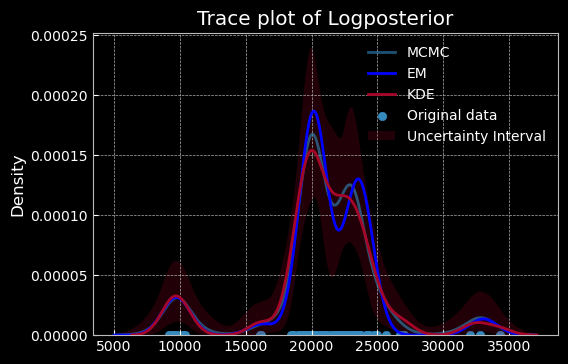

In [10]:
## Plot the final result distribution for various samples
fig, ax = plt.subplots(1, 1)
# Bayesian plot
ax.plot(xx, density_mcmc_m,  lw=2, alpha=0.6, label='MCMC') # Trace plot of data
# EM algorithm
ax.plot(xx, density_EM, 'blue', label = 'EM')
# KDE plot
ax = sns.kdeplot(x, bw_adjust = 0.5, label = 'KDE')
# Plotting original data
ax.scatter(np.array(x), np.zeros((x.shape[0])), label = 'Original data')
# Plotting uncertainty
plt.fill_between(xx, density_mcmc_uq, density_mcmc_lq, alpha=0.2,
                 label='Uncertainty Interval')
ax.legend(loc='best', frameon=False)
# plot density estimate of the posterior
plt.title('Trace plot of Logposterior')
plt.show()